<a href="https://colab.research.google.com/github/kabirodavies/ML_classification/blob/main/Climate_Change_Belief_Analysis_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Overview

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.


The structure of this notebook is as follows:


<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. The Dataset</a>

<a href=#three>3. Text Pre-processing & Data Cleaning</a>

<a href=#three>4. Exploratory Data Analysis (EDA)</a>

<a href=#four>5. Dealing with Imbalanced Data</a>

<a href=#five>6. Feature Extraction</a>

<a href=#five>7. Modeling</a>

<a href=#seven>8. File Submission</a>



 <a id="one"></a>
## 1.0 Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
 Description: Importing Packages 


In [127]:
%matplotlib inline
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
from nltk.corpus import stopwords
#Visuals
from wordcloud import WordCloud
## for bag-of-words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
# #for explainer
# from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api

#Data Imbalance
from sklearn.utils import resample

#Feature Eng
from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import LabeledSentence

#Encoding
from sklearn.preprocessing import LabelEncoder

#Algorithms
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

#Grid Search
from sklearn.model_selection import GridSearchCV

#Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Warnings
import warnings 

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

warnings.filterwarnings('ignore')

In [32]:
url_train = 'https://raw.githubusercontent.com/kabirodavies/ML_classification/main/train.csv'
url_test = 'https://raw.githubusercontent.com/kabirodavies/ML_classification/main/test.csv'
url_sub = 'https://raw.githubusercontent.com/kabirodavies/ML_classification/main/sample_submission.csv'


 <a id="one"></a>
## 2.0 The Dataset
<a href=#cont>Back to Table of Contents</a>

---
    
 Description: Bried overview of the data.


Data The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. Each tweet is labelled as one of the following classes:

##Class Description:
 

* 2 News: the tweet links to factual news about climate change
* 1 Pro: the tweet supports the belief of man-made climate change
* 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
* -1 Anti: the tweet does not believe in man-made climate change

##Columns:

*   sentiment: Sentiment of tweet i.e 0, 1, etc
*   message: Tweet body
*   tweetid: Twitter unique id








### Read the data

In [33]:
#Read the data
train = pd.read_csv(url_train)
train.head()

,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954


In [34]:
test = pd.read_csv(url_test)
test.head()

,message,tweetid
0,Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq,169760
1,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj,35326
2,"The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax,476263
4,RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican,872928


In [10]:
train.shape, test.shape

((15819, 3), (10546, 2))

In [15]:
train.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB


### To ease text cleaning, we're going to combine train and test data

In [35]:
combi = train.append(test, ignore_index=True, sort=True)
combi.shape

(26365, 3)

In [36]:
combi = train.append(test, ignore_index=True, sort=True)
combi.shape

(26365, 3)

<a id="one"></a>
## 3.0 Text Pre-processing & Data Cleaning
<a href=#cont>Back to Table of Contents</a>

---
    
 Description: Real world data is messy. This step is all about removing the noice from data. With the use of regualr expressions we can remove unwanted charecters which include: Emojis, digits, RT for retweets, Hashtags, symbols like @, !, $, &, urls.

Text preprocessing is a method to clean the text data and make it ready to feed data to the model.




In [37]:
nltk.download(['punkt','stopwords', 'wordnet'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
lst_stopwords = nltk.corpus.stopwords.words("english")

def utils_preprocess_text(message, flg_stemm=False, flg_lemm=True, lst_stopwords='english'):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(message).lower().strip())
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Remove @mentions
    text = re.sub(r'#', '', text) # Remove '#' symbol
    text = re.sub(r':', '', text) # Remove ':' symbol
    text = re.sub(r'rt[\s]+', '', text) #Remove RT
    text = re.sub(r'https?:\/\/\S+', '', text) # Remove hyperlink
    text = re.sub(r'\w*\d\w*', '', text) # Remove numbers
    text = re.sub('http\S+|www.\S+', '', text)
    text = re.sub(r'[^A-Za-z ]', '', text)
  
    text = re.sub('[.?]', '', text)
    text = re.sub('https?://\S+|www.\S+', '', text)
    text = re.sub('<.?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w\d\w', '', text)
    

              
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [43]:
combi["clean_message"] = combi["message"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

combi.head(20)

,message,sentiment,tweetid,clean_message
0,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",1.0,625221,polyscimajor epa chief doesnt think carbon dioxide main cause global warming wait via mashable
1,It's not like we lack evidence of anthropogenic global warming,1.0,126103,like lack evidence anthropogenic global warming
2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,2.0,698562,rawstory researcher say three year act climate change late
3,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,1.0,573736,todayinmaker wired pivotal year war climate change
4,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",1.0,466954,soynoviodetodas racist sexist climate change denying bigot leading poll electionnight
5,Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j,1.0,425577,worth read whether dont believe climate change
6,RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R,1.0,294933,thenation mike penny doesnt believe global warming smoking cause lung cancer
7,"RT @makeandmendlife: Six big things we can ALL do today to fight climate change, or how to be a climate activistÃ¢â‚¬Â¦ https://t.co/TYMLu6DbNM hÃ¢â‚¬Â¦",1.0,992717,makeandmendlife six big thing today fight climate change climate activist h
8,"@AceofSpadesHQ My 8yo nephew is inconsolable. He wants to die of old age like me, but will perish in the fiery hellscape of climate change.",1.0,664510,aceofspadeshq nephew inconsolable want die old age like perish fiery hellscape climate change
9,RT @paigetweedy: no offense… but like… how do you just not believe… in global warming………,1.0,260471,paigetweedy offense like believe global warming


<a id="one"></a>
## 4.0 Exploratory Data Analysis(EDA)
<a href=#cont>Back to Table of Contents</a>

---
    
 Description:


In [59]:
# Separating dataframes
train_df = combi.iloc[:15819,:]
test_df = combi.iloc[15819:,:]

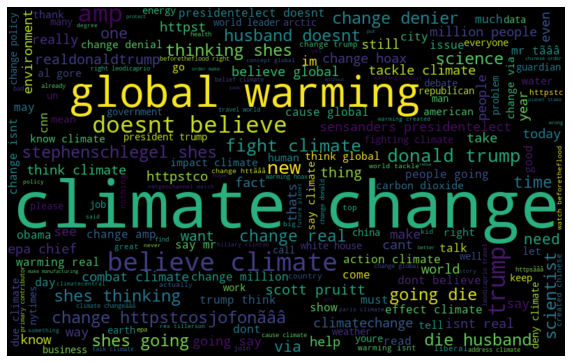

In [ ]:
#Most common words in the train data
all_words = ' '.join([text for text in train_df['clean_message']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

In [47]:
# Separate minority and majority classes
news = train_df[train_df['sentiment']==2]
support = train_df[train_df['sentiment']==1]
neutral = train_df[train_df['sentiment']==0]
anti = train_df[train_df['sentiment']==-1]

In [50]:
news_df = pd.DataFrame(train_df[train_df['sentiment']==2])
support_df = pd.DataFrame(train_df[train_df['sentiment']==1])
neutal_df = pd.DataFrame(train_df[train_df['sentiment']==0])
anti_df = pd.DataFrame(train_df[train_df['sentiment']==2])

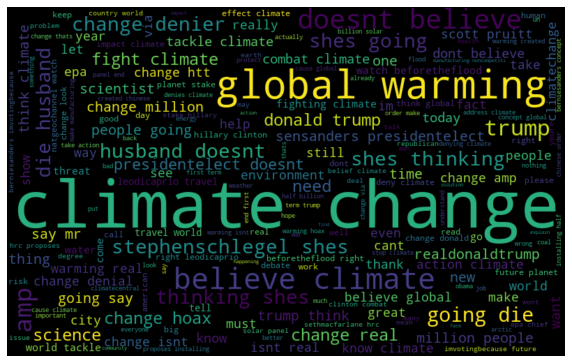

In [53]:
#Most common words tweeted by persons in support of climate change
all_words = ' '.join([text for text in support_df['clean_message']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

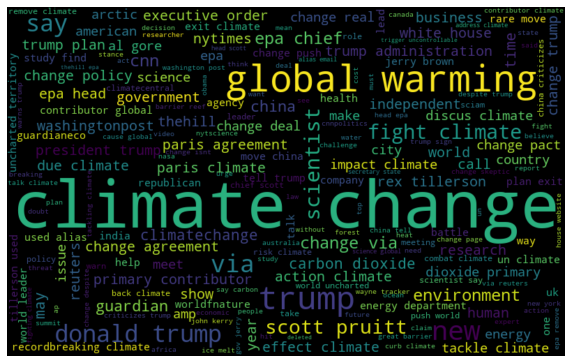

In [54]:
#Most common words tweeted by persons anti climate change
all_words = ' '.join([text for text in anti_df['clean_message']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

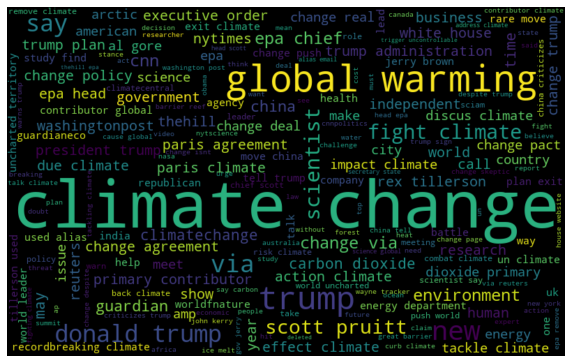

In [55]:
#Most common words tweeted by news outlest
all_words = ' '.join([text for text in news_df['clean_message']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

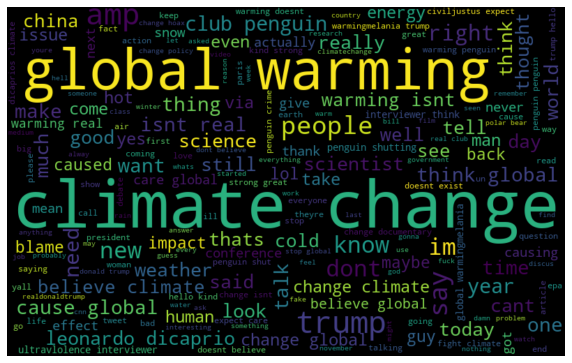

In [56]:
#Most common words tweeted by neutal persons
all_words = ' '.join([text for text in neutal_df['clean_message']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

<a id="one"></a>
## 5.0 Dealing with Imbalanced Data
<a href=#cont>Back to Table of Contents</a>

---
    
 Notes: We discovered upsampling didn't have an impact on the accuracy of our model

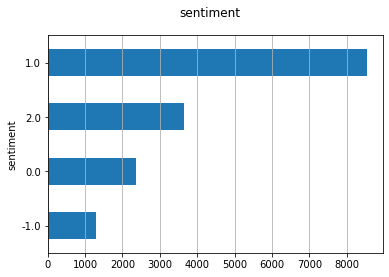

In [60]:
fig, ax = plt.subplots()
fig.suptitle("sentiment", fontsize=12)
train_df["sentiment"].reset_index().groupby("sentiment").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [61]:
# Sentiment percentage of data before resampling.
print(f' Support: {round(len(support)/(len(train_df))*100, 2)} %')
print(f' News: {round(len(news)/(len(train_df))*100, 2)} %')
print(f' Neutral: {round(len(neutral)/(len(train_df))*100, 2)} %')
print(f' Anti: {round(len(anti)/(len(train_df))*100, 2)} %')

 Support: 53.92 %
 News: 23.01 %
 Neutral: 14.87 %
 Anti: 8.19 %


In [74]:
# Upsample minority and combine with majority
anti_upsampled = resample(anti, replace=True, n_samples= len(support), random_state=123)
neutral_upsampled = resample(neutral, replace=True, n_samples=len(support), random_state=123)
news_upsampled = resample(news, replace=True, n_samples=len(support), random_state=123)

sampled = pd.concat([neutral_upsampled, news_upsampled, anti_upsampled, support])

In [75]:
# Separate minority and majority classes
up_news = sampled[sampled['sentiment']==2]
up_support = sampled[sampled['sentiment']==1]
up_neutral = sampled[sampled['sentiment']==0]
up_anti = sampled[sampled['sentiment']==-1]

In [76]:
len(up_news), len(up_support), len(up_neutral), len(up_anti)

(8530, 8530, 8530, 8530)

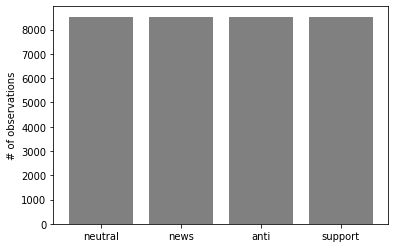

In [77]:
# Get all possible labels
labels = sampled['sentiment'].unique()
heights = [len(up_news),len(up_support), len(up_neutral), len(up_anti)]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['news', 'support','neutral', 'anti'])
plt.ylabel("# of observations")
plt.show()

<a id="one"></a>
## 6.0 Feature Extraction
<a href=#cont>Back to Table of Contents</a>

---
    
 Description:



###1. Bag-of-Words Features

In [78]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=10000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['message'])
bow.shape

(26365, 10000)

###2. TF-IDF Features

In [79]:
tv = TfidfVectorizer(min_df=2, max_df=0.90, max_features=10000, stop_words='english', ngram_range=(1,2))
tv.fit(combi['clean_message'])

TfidfVectorizer(max_df=0.9, max_features=10000, min_df=2, ngram_range=(1, 2),
                stop_words='english')

In [80]:
tv_train_transformed = tv.transform(combi['clean_message'])
tv_cv = tv_train_transformed.toarray()

In [81]:
train_tv_df = pd.DataFrame(tv_train_transformed.toarray(),
                     columns=tv.get_feature_names())\
                     .add_prefix('TFIDF_')

In [84]:
examine_row = train_tv_df.iloc[0]


In [85]:
print(examine_row.sort_values(ascending=False))

TFIDF_chief doesnt        0.306169
TFIDF_warming wait        0.306169
TFIDF_think carbon        0.299330
TFIDF_dioxide main        0.291110
TFIDF_main cause          0.264015
                            ...   
TFIDF_planet lifeblood    0.000000
TFIDF_planet global       0.000000
TFIDF_planet earth        0.000000
TFIDF_planet climate      0.000000
TFIDF_ab                  0.000000
Name: 0, Length: 10000, dtype: float64


In [86]:
out = train_tv_df.sum()

In [87]:
print(out.sort_values(ascending=False))

TFIDF_climate           1315.432794
TFIDF_change            1296.616093
TFIDF_climate change    1281.699939
TFIDF_global             822.081413
TFIDF_warming            787.370664
                           ...     
TFIDF_creat                1.141754
TFIDF_kerry urge           1.141754
TFIDF_center right         1.127521
TFIDF_trade center         1.127521
TFIDF_transi               1.050807
Length: 10000, dtype: float64


###3. Word2Vec Embedding

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

In [89]:
%%time
tokenized_text = combi['message'].apply(lambda x: x.split()) # tokenizing 

model_w2v = gensim.models.Word2Vec(
            tokenized_text,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(tokenized_text, total_examples= len(combi['message']), epochs=20)


CPU times: user 2min 56s, sys: 614 ms, total: 2min 56s
Wall time: 1min 32s


In [91]:
model_w2v.wv.most_similar(positive="food")

[('production.', 0.6103533506393433),
 ('breakÃ¢â‚¬Â¦', 0.5835883617401123),
 ('supplies', 0.5785775780677795),
 ('systems', 0.5651079416275024),
 ('Irresponsible', 0.5627463459968567),
 ('#GAID2017', 0.5531953573226929),
 ('menu', 0.5505306720733643),
 ('@Food_Tank:', 0.5446035861968994),
 ('protein', 0.5435446500778198),
 ('#SDGs…', 0.5306220650672913)]

In [92]:
model_w2v.most_similar(positive="trump")

[('donald', 0.5298982262611389),
 ('trump,', 0.5065931081771851),
 ('@sydneythememe:', 0.503343403339386),
 ('real???', 0.5012392997741699),
 ('tho', 0.4994841516017914),
 ('America:', 0.4967256486415863),
 ('Ã°Å¸â„¢â€ž', 0.49565672874450684),
 ('Lmfao', 0.4927007555961609),
 ('True,', 0.4924827814102173),
 ('trump...', 0.4900255799293518)]

In [95]:
# model_w2v['heat']

In [94]:
len(model_w2v['heat']) #The length of the vector is 200

200

###Preparing Vectors for text

In [96]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [98]:
wordvec_arrays = np.zeros((len(tokenized_text), 200)) 
for i in range(len(tokenized_text)):
    wordvec_arrays[i,:] = word_vector(tokenized_text[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(26365, 200)

###4. Doc2Vec Embedding

####To implement doc2vec, we have to labelise or tag each tokenised tweet with unique IDs. We can do so by using Gensim’s LabeledSentence() function.

In [100]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

labeled_text = add_label(tokenized_text) # label all the tweets

In [101]:
labeled_text[:6]

[LabeledSentence(words=['PolySciMajor', 'EPA', 'chief', "doesn't", 'think', 'carbon', 'dioxide', 'is', 'main', 'cause', 'of', 'global', 'warming', 'and..', 'wait,', 'what!?', 'https://t.co/yeLvcEFXkC', 'via', '@mashable'], tags=['tweet_0']),
 LabeledSentence(words=["It's", 'not', 'like', 'we', 'lack', 'evidence', 'of', 'anthropogenic', 'global', 'warming'], tags=['tweet_1']),
 LabeledSentence(words=['RT', '@RawStory:', 'Researchers', 'say', 'we', 'have', 'three', 'years', 'to', 'act', 'on', 'climate', 'change', 'before', 'it’s', 'too', 'late', 'https://t.co/WdT0KdUr2f', 'https://t.co/Z0ANPT…'], tags=['tweet_2']),
 LabeledSentence(words=['#TodayinMaker#', 'WIRED', ':', '2016', 'was', 'a', 'pivotal', 'year', 'in', 'the', 'war', 'on', 'climate', 'change', 'https://t.co/44wOTxTLcD'], tags=['tweet_3']),
 LabeledSentence(words=['RT', '@SoyNovioDeTodas:', "It's", '2016,', 'and', 'a', 'racist,', 'sexist,', 'climate', 'change', 'denying', 'bigot', 'is', 'leading', 'in', 'the', 'polls.', '#Elect

##Now let’s train a doc2vec model.

In [102]:
%%time 
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 5.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 ) 

model_d2v.build_vocab([i for i in tqdm(labeled_text)])

model_d2v.train(labeled_text, total_examples= len(train['message']), epochs=15)

100%|██████████| 26365/26365 [00:00<00:00, 2293060.13it/s]


CPU times: user 1min 16s, sys: 19.4 s, total: 1min 36s
Wall time: 1min 8s


####Preparing doc2vec Feature Set

In [105]:
docvec_arrays = np.zeros((len(tokenized_text), 200)) 
for i in range(len(combi)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1, 200))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(26365, 200)

In [106]:
docvec_df.shape,  wordvec_df.shape

((26365, 200), (26365, 200))

In [107]:
train.shape, test.shape

((15819, 3), (10546, 2))

In [108]:
# Extracting train and test BoW features 
train_bow = bow[:15819,:] 
test_bow = bow[15819:,:]

In [ ]:
#Encoding
# le = LabelEncoder()
# Transforming categorical variable to label encoded form
# train['lang_id'] = le.fit_transform(train['lang_id'])
# data['lang_id'] = le.inverse_transform(data['lang_id'])
# data['lang_id'] 

 <a id="one"></a>
## 7.0 Modeling
<a href=#cont>Back to Table of Contents</a>

---
    
 Description: Done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:


1.   Logistic Regression
2.   Support Vector Machine
3.   RandomForest
4.   XGBoost
5.   Multinomial Naive Bayes Classifier

## 1.0 Logistic Regression

###Bag-of-Words Features







In [111]:
# Extracting train and test BoW features 
train_bow = bow[:15819,:] 
test_bow = bow[15819:,:]

# splitting data into training and validation set 
X_train, X_test, y_train, y_test = train_test_split(train_bow, train['sentiment'], random_state=42, test_size=0.2)

lreg = LogisticRegression(solver='lbfgs') 

# training the model 
lreg.fit(X_train, y_train) 

y_pred = lreg.predict(X_test) # predicting

In [112]:
pred_y = lreg.predict(X_test) #Prediction of Test set
pred_y_train = lreg.predict(X_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(y_train, pred_y_train))
print('Test Accuracy', accuracy_score(y_test, pred_y))
print('Classification Report', classification_report(y_test, pred_y))

Train Accuracy 0.9398656657447649
Test Accuracy 0.7487357774968394
Classification Report               precision    recall  f1-score   support

          -1       0.73      0.44      0.55       278
           0       0.53      0.52      0.52       425
           1       0.79      0.85      0.82      1755
           2       0.78      0.77      0.77       706

    accuracy                           0.75      3164
   macro avg       0.71      0.64      0.67      3164
weighted avg       0.75      0.75      0.74      3164



### TF-ID Features

In [120]:
train_tf = tv_cv[:15819,:] 
test_tf = tv_cv[15819:,:]

In [121]:
# splitting data into training and validation set 
tX_train, tX_test, ty_train, ty_test = train_test_split(train_tf, train['sentiment'], random_state=42, test_size=0.3)

td_lreg = LogisticRegression(solver='lbfgs') 

# training the model 
td_lreg.fit(tX_train, ty_train) 

td_y_pred = td_lreg.predict(tX_test) # predicting

In [122]:
pred_y = td_lreg.predict(tX_test) #Prediction of Test set
pred_y_train = td_lreg.predict(tX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(ty_train, pred_y_train))
print('Test Accuracy', accuracy_score(ty_test, pred_y))
print('Classification Report', classification_report(ty_test, pred_y))

Train Accuracy 0.8318432222523254
Test Accuracy 0.7258744205646861
Classification Report               precision    recall  f1-score   support

          -1       0.86      0.30      0.45       401
           0       0.65      0.35      0.46       666
           1       0.72      0.91      0.80      2598
           2       0.77      0.66      0.71      1081

    accuracy                           0.73      4746
   macro avg       0.75      0.56      0.61      4746
weighted avg       0.73      0.73      0.70      4746



###Word2Vec Features

In [123]:
# Extracting train and test Word2Vec features 
train_w2v = wordvec_df.iloc[:15819,:]
test_w2v = wordvec_df.iloc[15819:,:]

# splitting data into training and validation set 
wX_train, wX_test, wy_train, wy_test = train_test_split(train_w2v, train['sentiment'], random_state=42, test_size=0.2)

w_lreg = LogisticRegression(solver='lbfgs') 

# training the model 
w_lreg.fit(wX_train, wy_train) 

LogisticRegression()

In [124]:
pred_y = w_lreg.predict(wX_test) #Prediction of Test set
pred_y_train = w_lreg.predict(wX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(wy_train, pred_y_train))
print('Test Accuracy', accuracy_score(wy_test, pred_y))
print('Classification Report', classification_report(wy_test, pred_y))

Train Accuracy 0.7167917819043856
Test Accuracy 0.7079646017699115
Classification Report               precision    recall  f1-score   support

          -1       0.50      0.22      0.31       278
           0       0.54      0.38      0.45       425
           1       0.73      0.85      0.79      1755
           2       0.74      0.75      0.74       706

    accuracy                           0.71      3164
   macro avg       0.63      0.55      0.57      3164
weighted avg       0.69      0.71      0.69      3164



###Doc2Vec Features

In [125]:
# Extracting train and test Doc2Vec features 
train_d2v = docvec_df.iloc[:15819,:]
test_d2v = docvec_df.iloc[15819:,:]

# splitting data into training and validation set 
dX_train, dX_test, dy_train, dy_test = train_test_split(train_d2v, train['sentiment'], random_state=42, test_size=0.3)

d_lreg = LogisticRegression(solver='lbfgs') 

# training the model 
d_lreg.fit(dX_train, dy_train) 

# predicting
d_y_pred = d_lreg.predict(dX_test) 

In [126]:
pred_y = d_lreg.predict(dX_test) #Prediction of Test set
pred_y_train = d_lreg.predict(dX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(dy_train, pred_y_train))
print('Test Accuracy', accuracy_score(dy_test, pred_y))
print('Classification Report', classification_report(dy_test, pred_y))

Train Accuracy 0.6165447484873114
Test Accuracy 0.6002949852507374
Classification Report               precision    recall  f1-score   support

          -1       0.45      0.12      0.20       401
           0       0.40      0.19      0.26       666
           1       0.63      0.83      0.72      2598
           2       0.58      0.46      0.51      1081

    accuracy                           0.60      4746
   macro avg       0.52      0.40      0.42      4746
weighted avg       0.57      0.60      0.56      4746



In [ ]:
#Tuning Logist Reg with TF-IDF
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)

logreg_cv.fit(tX_train ,ty_train) #Fit Data

log_pred = logreg_cv.predict(tX_test)
#Metrics
# print(confusion_matrix(y_test, y_pred))
print(accuracy_score(ty_test, log_pred))
print(classification_report(ty_test, log_pred))
# pd.crosstab(y_test,y_pred)

#2. Support Vector Machine (SVM)


###Bag-of-Words Features

In [ ]:
svc = svm.SVC(kernel='linear', C=1, probability=True)
svc.fit(X_train, y_train) 
svc_y_pred = svc.predict(X_test) # predicting

In [ ]:
#Metrics
print(accuracy_score(y_test, svc_y_pred))
print(classification_report(y_test, svc_y_pred))

0.6858407079646017
              precision    recall  f1-score   support

          -1       0.53      0.47      0.50       401
           0       0.45      0.51      0.48       666
           1       0.76      0.77      0.77      2598
           2       0.71      0.67      0.69      1081

    accuracy                           0.69      4746
   macro avg       0.61      0.60      0.61      4746
weighted avg       0.69      0.69      0.69      4746



###TF-IDF Features

In [ ]:
# training the model
t_svc = svm.SVC(kernel='linear', C=1, probability=True)
t_svc.fit(tX_train, ty_train)  
tsvc_y_pred = t_svc.predict(tX_test)

In [ ]:
#Metrics
print(accuracy_score(ty_test, svc_y_pred))
print(classification_report(ty_test, svc_y_pred))

0.6858407079646017
              precision    recall  f1-score   support

          -1       0.53      0.47      0.50       401
           0       0.45      0.51      0.48       666
           1       0.76      0.77      0.77      2598
           2       0.71      0.67      0.69      1081

    accuracy                           0.69      4746
   macro avg       0.61      0.60      0.61      4746
weighted avg       0.69      0.69      0.69      4746



###Word2Vec Features



In [ ]:
s_w_svc = svm.SVC(kernel='linear', C=1, probability=True) 

# training the model 
s_w_svc.fit(wX_train, wy_train)
s_y_pred = s_w_svc.predict(wX_test) # predicting

#Metrics
print(accuracy_score(wy_test, s_y_pred))
print(classification_report(wy_test, s_y_pred))

0.5474083438685209
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       401
           0       0.00      0.00      0.00       666
           1       0.55      1.00      0.71      2598
           2       0.00      0.00      0.00      1081

    accuracy                           0.55      4746
   macro avg       0.14      0.25      0.18      4746
weighted avg       0.30      0.55      0.39      4746



###Doc2Vec Features

In [ ]:
doc_svc = svm.SVC(kernel='linear', C=1, probability=True) 

# training the model 
doc_svc.fit(dX_train, dy_train)
doc_pred = doc_svc.predict(dX_test) # predicting

#Metrics
print(accuracy_score(dy_test, doc_pred))
print(classification_report(dy_test, doc_pred))

0.5474083438685209
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       401
           0       0.00      0.00      0.00       666
           1       0.55      1.00      0.71      2598
           2       0.00      0.00      0.00      1081

    accuracy                           0.55      4746
   macro avg       0.14      0.25      0.18      4746
weighted avg       0.30      0.55      0.39      4746



#3.0 RandomForest

###Bag of Words

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(X_train, y_train) 
prediction = rf.predict(X_test)

In [ ]:
#Metrics
print(accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))

0.5745891276864729
              precision    recall  f1-score   support

          -1       0.43      0.02      0.05       401
           0       0.39      0.11      0.17       666
           1       0.60      0.85      0.70      2598
           2       0.50      0.42      0.46      1081

    accuracy                           0.57      4746
   macro avg       0.48      0.35      0.34      4746
weighted avg       0.54      0.57      0.52      4746



###TF-IDF Features

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(tX_train, ty_train) 
prediction = rf.predict(tX_test)

In [ ]:
#Metrics
print(accuracy_score(ty_test, prediction))
print(classification_report(ty_test, prediction))

0.6820480404551201
              precision    recall  f1-score   support

          -1       0.73      0.27      0.40       401
           0       0.50      0.36      0.42       666
           1       0.71      0.85      0.77      2598
           2       0.68      0.63      0.66      1081

    accuracy                           0.68      4746
   macro avg       0.65      0.53      0.56      4746
weighted avg       0.67      0.68      0.66      4746



###Word2Vec Features

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(wX_train, wy_train) 
prediction = rf.predict(wX_test)

In [ ]:
#Metrics
print(accuracy_score(wy_test, prediction))
print(classification_report(wy_test, prediction))

0.5474083438685209
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       401
           0       0.00      0.00      0.00       666
           1       0.55      1.00      0.71      2598
           2       0.00      0.00      0.00      1081

    accuracy                           0.55      4746
   macro avg       0.14      0.25      0.18      4746
weighted avg       0.30      0.55      0.39      4746



###Doc2Vec Features

In [ ]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(dX_train, dy_train) 
prediction = rf.predict(dX_test)

In [ ]:
#Metrics
print(accuracy_score(dy_test, prediction))
print(classification_report(dy_test, prediction))

0.5745891276864729
              precision    recall  f1-score   support

          -1       0.75      0.01      0.01       401
           0       0.56      0.02      0.04       666
           1       0.58      0.91      0.71      2598
           2       0.53      0.32      0.40      1081

    accuracy                           0.57      4746
   macro avg       0.61      0.32      0.29      4746
weighted avg       0.58      0.57      0.49      4746



#4.XGBoost


###Bag of Words Features

In [ ]:
# training the model 
b_xgb_model = XGBClassifier(max_depth=6, n_estimators=1000)
b_xgb_model.fit(X_train, y_train)


XGBClassifier(max_depth=6, n_estimators=1000, objective='multi:softprob')

In [ ]:
pred_y = b_xgb_model.predict(X_test) #Prediction of Test set
pred_y_train = b_xgb_model.predict(X_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(y_train, pred_y_train))
print('Test Accuracy', accuracy_score(y_test, pred_y))
print('Classification Report', classification_report(y_test, pred_y))

Train Accuracy 0.8272926500337154
Test Accuracy 0.7041719342604298
Classification Report               precision    recall  f1-score   support

          -1       0.75      0.38      0.51       325
           0       0.59      0.35      0.44       590
           1       0.71      0.88      0.78      2137
           2       0.74      0.63      0.68       903

    accuracy                           0.70      3955
   macro avg       0.70      0.56      0.60      3955
weighted avg       0.70      0.70      0.69      3955



###TF-IDF Features



In [ ]:
# training the model 
tf_xgb_model = XGBClassifier(max_depth=100, n_estimators=1000)
tf_xgb_model.fit(tX_train, ty_train)

KeyboardInterrupt: ignored

In [ ]:
pred_y = tf_xgb_model.predict(tX_test) #Prediction of Test set
pred_y_train = tf_xgb_model.predict(tX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(ty_train, pred_y_train))
print('Test Accuracy', accuracy_score(ty_test, pred_y))
print('Classification Report', classification_report(ty_test, pred_y))

###Word2Vec Features

In [ ]:
# training the model 
xgb = XGBClassifier()
xgb.fit(wX_train, wy_train) 

XGBClassifier(objective='multi:softprob')

In [ ]:
pred_y = xgb.predict(wX_test) #Prediction of Test set
pred_y_train = xgb.predict(wX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(wy_train, pred_y_train))
print('Test Accuracy', accuracy_score(wy_test, pred_y))
print('Classification Report', classification_report(wy_test, pred_y))

Train Accuracy 0.5353615171868826
Test Accuracy 0.554677623261694
Classification Report               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       278
           0       0.00      0.00      0.00       425
           1       0.55      1.00      0.71      1755
           2       0.00      0.00      0.00       706

    accuracy                           0.55      3164
   macro avg       0.14      0.25      0.18      3164
weighted avg       0.31      0.55      0.40      3164



###Doc2Vec Features

In [ ]:
# # training the model 
# xgb_model = XGBClassifier(max_depth=6, n_estimators=1000)
# xgb_model.fit(dX_train, dy_train)
# prediction = xgb_model.predict(dX_test)

In [ ]:
#Metrics
print(accuracy_score(dy_test, prediction))
print(classification_report(dy_test, prediction))

0.7026970080067425
              precision    recall  f1-score   support

          -1       0.70      0.37      0.49       401
           0       0.58      0.38      0.46       666
           1       0.71      0.87      0.78      2598
           2       0.72      0.63      0.67      1081

    accuracy                           0.70      4746
   macro avg       0.68      0.56      0.60      4746
weighted avg       0.70      0.70      0.69      4746



###Tuning XBBOOST

In [ ]:
colsample_bytree = [0.3, 0.5, 1.0]
gamma = [0.1, 1, 1.5]
learning_rate = [0.001, 0.01]
min_child_weight = [1, 5, 10]
scale_pos_weight = [1, 2, 4]
subsample = [0.8, 0.9, 1.0]
n_estimators = [50, 100, 150]
max_depth = [5, 100]

param_grid = dict(
    colsample_bytree=colsample_bytree,
    gamma=gamma,
    learning_rate=learning_rate,
    min_child_weight=min_child_weight,
    scale_pos_weight=scale_pos_weight,
    subsample=subsample,
    n_estimators=n_estimators,
    max_depth=max_depth,
)

In [ ]:
model = XGBClassifier(random_state=1, verbosity=1)

grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           )
best_model = grid_search.fit(X_train, y_train)
print('Optimum parameters', best_model.best_params_)

In [ ]:
tuned_model = XGBClassifier(random_state=1, 
                            colsample_bytree=0.3, 
                            gamma=1, 
                            learning_rate=0.01, 
                            max_depth=5, 
                            min_child_weight=1,
                            n_estimators=100,
                            scale_pos_weight=2, 
                            subsample=0.9)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(tuned_model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC/AUC = ', scores.mean())

# 5. Multinomial Naive Bayes Classifier

####Bag of Words Features

In [ ]:

#Create MultinomialNB object
clf = MultinomialNB(alpha=0.6)
# Train clf
clf.fit(X_train, y_train)

MultinomialNB(alpha=0.6)

In [ ]:
pred_y = clf.predict(X_test) #Prediction of Test set
pred_y_train = clf.predict(X_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(y_train, pred_y_train))
print('Test Accuracy', accuracy_score(y_test, pred_y))
print('Classification Report', classification_report(y_test, pred_y))

Train Accuracy 0.8331085637221848
Test Accuracy 0.7008849557522124
Classification Report               precision    recall  f1-score   support

          -1       0.61      0.44      0.51       325
           0       0.52      0.45      0.48       590
           1       0.76      0.80      0.78      2137
           2       0.68      0.73      0.71       903

    accuracy                           0.70      3955
   macro avg       0.64      0.60      0.62      3955
weighted avg       0.69      0.70      0.70      3955



###TF-IDF Features

In [ ]:
tf_clf = MultinomialNB(alpha=0.6).fit(tX_train, ty_train)
# Compute Prediction
prediction = tf_clf.predict(tX_test)

In [ ]:
pred_y = tf_clf.predict(tX_test) #Prediction of Test set
pred_y_train = tf_clf.predict(tX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(ty_train, pred_y_train))
print('Test Accuracy', accuracy_score(ty_test, pred_y))
print('Classification Report', classification_report(ty_test, pred_y))

Train Accuracy 0.7632556301856973
Test Accuracy 0.6690897597977244
Classification Report               precision    recall  f1-score   support

          -1       0.92      0.13      0.24       267
           0       0.68      0.15      0.24       465
           1       0.65      0.94      0.76      1711
           2       0.76      0.56      0.65       721

    accuracy                           0.67      3164
   macro avg       0.75      0.45      0.47      3164
weighted avg       0.70      0.67      0.62      3164



###Word2Vec Features

In [ ]:
w_clf = MultinomialNB(alpha=0.6).fit(wX_train, wy_train)
# Compute Prediction
prediction = w_clf.predict(wX_test)

In [ ]:
pred_y = w_clf.predict(wX_test) #Prediction of Test set
pred_y_train = w_clf.predict(wX_train) #Prediction of Train set
#Metrics
print('Train Accuracy', accuracy_score(wy_train, pred_y_train))
print('Test Accuracy', accuracy_score(wy_test, pred_y))
print('Classification Report', classification_report(wy_test, pred_y))

Train Accuracy 0.5353615171868826
Test Accuracy 0.554677623261694
Classification Report               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       278
           0       0.00      0.00      0.00       425
           1       0.55      1.00      0.71      1755
           2       0.00      0.00      0.00       706

    accuracy                           0.55      3164
   macro avg       0.14      0.25      0.18      3164
weighted avg       0.31      0.55      0.40      3164



#Predict Test data for submission.


In [113]:
#To predict the test data for kaggle submission.
# final_pred = xgb.predict(test_w2v)

final_pred = lreg.predict(test_bow) #TF-IDF)


#Saving Best Performing Models

In [ ]:
#Save Model XGBOOST With Pickle
import pickle

model_save_path = "xgb_model.pkl" #SVM
with open(model_save_path,'wb') as file:
    pickle.dump(xgb,file)

In [ ]:
#Open Model With Pickle
model_load_path = "xgb_model.pkl"
with open(model_load_path,'rb') as file:
    unpickled_model = pickle.load(file)

In [ ]:
# get predictions from unpickled model
xgb_pred = unpickled_model.predict(wX_test)

In [128]:
#Save Model Logistic Reg With Pickle
import pickle
model_save_path = "log_model.pkl" #SVM
with open(model_save_path,'wb') as file:
    pickle.dump(lreg, file)

 <a id="one"></a>
## 7.0 File Submission
<a href=#cont>Back to Table of Contents</a>

---
    
 Description: Generate and submit CSV file to Kaggle

In [114]:
sub = pd.read_csv(url_sub)
sub.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [115]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['tweetid'] = test['tweetid']
submission['sentiment'] = final_pred # our model predictions on the test dataset
submission.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0


In [116]:
# for Kaggle submisison
submission.to_csv('climate_change.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [117]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("climate_change.csv")
submissions_check.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0


In [ ]:
submission.shape

(10546, 2)

In [118]:
from google.colab import files
files.download("climate_change.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>